# DenseReg: Fully Convolutional Dense Shape Regression In-the-Wild


- First, setting up cv2, matplotlib, numpy, etc. 
- Load Caffe

Make sure that your path (my_caffe below) is correct.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
from scipy.io import loadmat
from PIL import Image
from scipy.misc import imresize
import copy

# Loading caffe !
import sys
sys.path.append("DeepLab-Context2/python")
import caffe
import time

- Setting in gpu mode and selecting gpu
- Selecting deploy prototxt and trained DenseReg model.
- Create the net.

In [2]:
caffe.set_mode_gpu()
caffe.set_device(1)

deployFile= "model/deployHuman.prototxt"
caffemodel= "model/DenseReg_Human_Release.caffemodel" # Model with $K=10$

net = caffe.Net(deployFile, caffemodel, caffe.TEST)
mean= (104.00699, 116.66877, 122.67892)


Read an image, resize the image such that its size is $8K+1$, where $K$ is an intager (to keep the size after downsampling).

Make a forward pass with the image data as input.

Visualize the patches $Index$ and regressed coordinates $U$ and $V$.



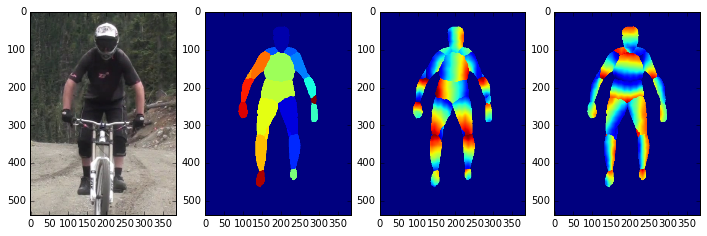

In [3]:
# Load and resizethe image.
I = np.array( Image.open("TestImages/1.png") )
New_size_x = np.int(8 * np.round(I.shape[0]/8.) + 1)
New_size_y = np.int(8 * np.round(I.shape[1]/8.) + 1)
I_resized = imresize(I,[New_size_x,New_size_y]).astype(np.float32)
# Subtract the mean value.
im = copy.deepcopy(I_resized[:,:,::-1])
im -= mean

im_input = np.transpose(im[:,:,::-1,np.newaxis], (3,2,0,1))
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input
#Net is reshaped and input is set. now forward..
net.forward()

Index = np.squeeze( copy.deepcopy(net.blobs['Index_zoom_argmax'].data[...] ) )
U= np.squeeze( copy.deepcopy(net.blobs['U_Out'].data[...] ) )
V= np.squeeze( copy.deepcopy(net.blobs['V_Out'].data[...] ) )

#Visualize
f, axarr = plt.subplots(1, 4, figsize=(12,8))
axarr[0].imshow( np.uint8( I_resized) )
axarr[1].imshow(Index)
axarr[2].imshow(U)
axarr[3].imshow(V)


Create a color image by filling HSV values to visualize the coordinates.

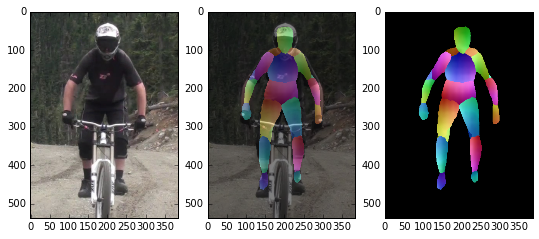

In [4]:
## A CUSTOM CODE TO VISUALIZE

# get HSV values using indices and 
Label_Vis_1 = np.zeros(Index.shape)
Label_Vis_2 = np.zeros(Index.shape)
for i in xrange(1,26):
     temp =  i  +  ( (Index==i) * U ) 
     Label_Vis_1[Index==i] = temp[Index==i]
for i in xrange(1,26):
     temp =    ( (Index==i) * V ) 
     Label_Vis_2[Index==i] = temp[Index==i]
H = Label_Vis_1/5- np.floor(Label_Vis_1/5);
S = Label_Vis_2/2+ (1/2.) ;
V = 1-Label_Vis_2/2 ;

hsvimg = np.zeros([Index.shape[0],Index.shape[1],3])

hsvimg[:,:,0] = H*179 #179 is max for Hue channel.
hsvimg[:,:,1] = S*255
hsvimg[:,:,2] = V*255 * np.double(Index>0)

rgbimg = cv2.cvtColor(hsvimg.astype(np.uint8), cv2.COLOR_HSV2RGB)

#Visualize
f, axarr = plt.subplots(1, 3, figsize=(9,8))
axarr[0].imshow( np.uint8( I_resized) )
axarr[1].imshow( np.uint8( I_resized/2+rgbimg/2) )
axarr[2].imshow(rgbimg)


